In [1]:
import numpy as np
import matplotlib.pyplot as plt
import igraph
import pandas as pd
import scipy.sparse.linalg as LA
from scipy import sparse
import time
from scipy.stats import bernoulli


In [2]:
red = ['#E87E72', '#F8E3E1']
green = ['#86AC34', '#E6EED5']
blue = ['#56BCC2', '#D8F1F3']
purple = ['#BC7FF8', '#F1E5FE']

In [3]:
colours = [red[0], green[0], blue[0], purple[0]]

In [4]:
coauthorship = igraph.Graph.Read_Ncol("CA-HepPh.txt")

In [5]:
A = coauthorship.get_adjacency()
A = np.array(A.data)
A_sparse = sparse.csr_matrix.asfptype(A)

In [6]:
# Fast Triangle counter for a sparse adjacency matrix
def fast_triangle_counter(A):
    C = (A @ A).multiply(A)
    n_tri = C.sum() // 6
    return n_tri

In [7]:
sA = sparse.csr_matrix(A)
fast_triangle_counter(sA)

3359103

In [8]:
def embedding_tri_count(d, w, v, I_pq):
    # d-dimensional spectral embedding
    X = v[:,0:d] @ np.diag(abs(w[0:d])**(1/2))
        
    # create probability matrix  
    P = X @ I_pq[0:d,0:d] @ X.transpose()
    P[P < 0] = 0
    P[P > 1] = 1
        
    #sample adjacency matrix
    new_A = sparse.coo_matrix(bernoulli.rvs(P))
      
    # count triangles
    tri_count = fast_triangle_counter(new_A)
    return tri_count

## Max degree graphs

In [9]:
def max_degree_triangles(A, c_vals):
    
    degrees = np.sum(A, axis=0)
    n = len(c_vals)
    triangles = np.zeros(n)
    
    for i in range(n):  
        low_deg_idx = degrees < c_vals[i]
        low_deg_A = sparse.coo_matrix(A[low_deg_idx, :][:,low_deg_idx])
        triangles[i] = fast_triangle_counter(low_deg_A)
    
    return triangles

In [13]:
start = time.time()

c_vals = list(range(3,11,1)) + [15, 30] + list(range(50, 701, 50))
triangles_original = max_degree_triangles(A, c_vals)

end = time.time()
print(end-start)

21.914947748184204


In [30]:
def embedding_max_degree_triangles(d, w, v, I_pq, c_vals):
    
    # d-dimensional spectral embedding
    X = v[:,0:d] @ np.diag(abs(w[0:d])**(1/2))
        
    # create probability matrix  
    P = X @ I_pq[0:d,0:d] @ X.transpose()
    P[P < 0] = 0
    P[P > 1] = 1
    
    n = len(c_vals)
    triangles = np.zeros(n)
    #sample adjacency matrix
    for i in range(100):
        new_A = bernoulli.rvs(P)
        new_triangles = max_degree_triangles(new_A, c_vals)
        triangles = triangles + new_triangles
    
    return triangles/100

In [12]:
def embedding_max_degree_triangles_av(d, w, v, I_pq, c_vals):
    
    # d-dimensional spectral embedding
    X = v[:,0:d] @ np.diag(abs(w[0:d])**(1/2))
        
    # create probability matrix  
    P = X @ I_pq[0:d,0:d] @ X.transpose()
    P[P < 0] = 0
    P[P > 1] = 1
        
    triangles = max_degree_triangles(P, c_vals)
    
    return triangles

In [15]:

start = time.time()

embedding_dims = [10, 100, 1000]
c_vals = list(range(3,11,1)) + [15, 30] + list(range(50, 701, 50))

max_d = embedding_dims[-1]
w, v = LA.eigsh(A_sparse, k=max_d)
idx = np.argsort(abs(w))[::-1]
w = w[idx]
v = v[:,idx]
I_pq = np.diag([1 if val>=0 else -1 for val in w])


triangles = [embedding_max_degree_triangles(d, w, v, I_pq, c_vals) 
            for d in embedding_dims
            ]

end = time.time()
print(end - start)

1066.103792667389


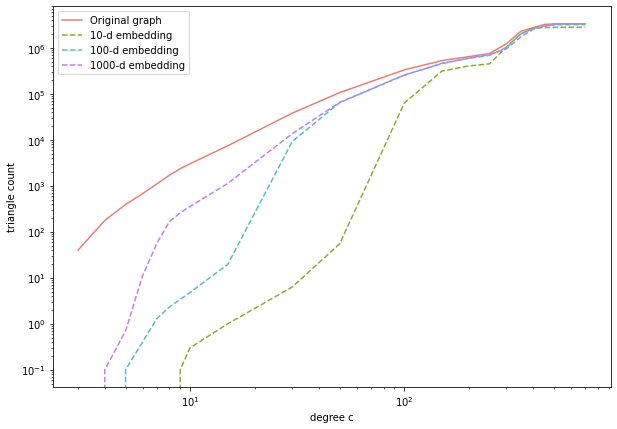

In [39]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(c_vals, triangles_original, c=colours[0], label= 'Original graph')

for i in range(len(embedding_dims)):
    d = embedding_dims[i]
    ax.plot(c_vals, triangles[i], c=colours[i+1], label = (str(d) + '-d embedding'), linestyle='--')

plt.xlabel('degree c')
plt.ylabel('triangle count')
plt.legend()
ax.set_yscale('log')
ax.set_xscale('log')

## Local embeddings

In [27]:
start = time.time()

shared = sA.transpose() @ sA
local_triangles_original = np.zeros((50, len(local_c_vals)))

local_embedding_dims = [5, 50]
max_d = local_embedding_dims[-1]
local_triangles = np.zeros((50, len(local_embedding_dims), len(local_c_vals)))


for i in range(50):
    node = np.random.randint(0,sA.shape[0]-1)
    neighbourhood = np.argsort(np.squeeze(np.asarray(shared[node,:].todense())))[-500:]
    local_A = A[neighbourhood, :][:, neighbourhood]
    local_triangles_original[i,:] = max_degree_triangles(local_A, local_c_vals)
    
    w, v = LA.eigsh(sparse.csr_matrix.asfptype(local_A), k=max_d)
    idx = np.argsort(abs(w))[::-1]
    w = w[idx]
    v = v[:,idx]
    I_pq = np.diag([1 if val>=0 else -1 for val in w])

    for j in range(len(local_embedding_dims)):
        local_triangles[i,j,:] = embedding_max_degree_triangles(local_embedding_dims[j], w, v, I_pq, local_c_vals) 
            
end = time.time()
print(end - start)

1384.0038766860962


Text(0.5, 1.0, 'Local embedding')

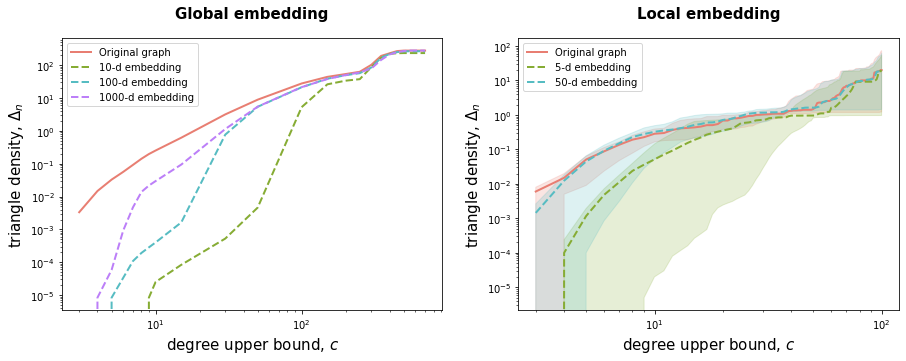

In [40]:
import seaborn as sns
n = A.shape[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(c_vals, triangles_original/n, c=colours[0], label= 'Original graph', linewidth=2)
for i in range(len(embedding_dims)):
    d = embedding_dims[i]
    ax1.plot(c_vals, triangles[i]/n, c=colours[i+1], label = (str(d) + '-d embedding'), linewidth=2, linestyle='--')

ax1.set_xlabel('degree upper bound, $c$', fontsize=15)
ax1.set_ylabel('triangle density, $\Delta_n$', fontsize=15)
ax1.legend()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Global embedding', fontsize=15, fontweight='bold', pad=20)


ax2.plot(local_c_vals, np.percentile(local_triangles_original, 50, axis=0)/500, c=colours[0], label= 'Original graph', linewidth=2)   
ax2.fill_between(local_c_vals, np.percentile(local_triangles_original, 25, axis=0)/500, 
                 np.percentile(local_triangles_original, 75, axis=0)/500, color=colours[0], alpha=0.2)
for i in range(len(local_embedding_dims)):
    d = local_embedding_dims[i]
    ax2.plot(local_c_vals, np.percentile(local_triangles, 50, axis=0)[i]/500, c=colours[i+1], label = (str(d) + '-d embedding'), linewidth=2, linestyle='--')
    ax2.fill_between(local_c_vals, np.percentile(local_triangles, 25, axis=0)[i]/500, 
                 np.percentile(local_triangles, 75, axis=0)[i]/500, color=colours[i+1], alpha=0.2)
     

plt.xlabel('degree upper bound, $c$', fontsize=15)
plt.ylabel('triangle density, $\Delta_n$', fontsize=15)
plt.legend(loc='upper left')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Local embedding', fontsize=15, fontweight='bold', pad=20)

#fig.savefig('local_v_global2.png', bbox_inches='tight', dpi=400)